In [25]:
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from evaluation import get_actual_demand


In [26]:
demand = pd.read_csv('./data/demand.csv')
demand

,time_step,latency_sensitivity,CPU.S1,CPU.S2,CPU.S3,CPU.S4,GPU.S1,GPU.S2,GPU.S3
0,1,high,4000,0,0,0,30,0,0
1,2,high,8160,0,0,0,61,0,0
2,3,high,11016,0,0,0,95,0,0
3,4,high,13953,0,0,0,130,0,0
4,5,high,19186,0,0,0,168,0,0
...,...,...,...,...,...,...,...,...,...
499,164,low,0,0,243279,748553,0,763,4629
500,165,low,0,0,255443,785981,0,733,4767
501,166,low,0,0,268216,825280,0,700,4908
502,167,low,0,0,281626,866544,0,666,5055


In [27]:
 
seeds = range(0,1000)

In [28]:


def getSeedDemand(seed):
    

    ## set random seed for numpy
    np.random.seed(seed)

    # get the demand under this seed
    seeded_demand = get_actual_demand(demand)

    return seeded_demand

    

In [29]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [30]:
server_type = "CPU.S1"

In [31]:
class predictModel(torch.nn.Module):


    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(predictModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


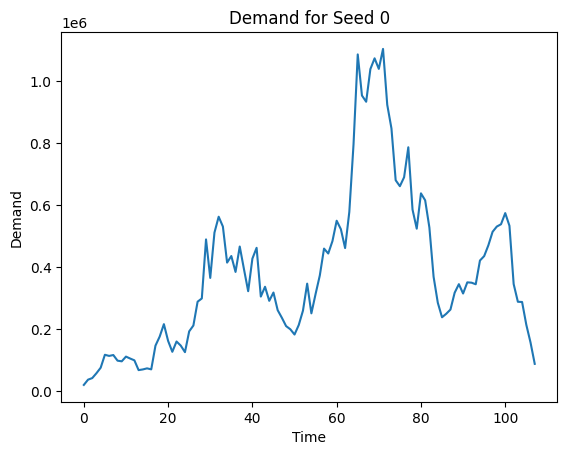

In [32]:



demand_0 = getSeedDemand(0)


demand_0 = demand_0.loc[    (demand_0["server_generation"]==server_type)]["low"]

demand_0 = demand_0.reset_index(drop=True)
                    # ts_demand = self.demand.loc[(self.demand['time_step']==self.timestep)].copy()

# Plot the historical data
plt.plot(demand_0)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title(f"Demand for Seed 0")
plt.show()

In [33]:
seeded_demands =[getSeedDemand(s) for s in seeds]
seeded_demands = [ 
                    sd.loc[
                            (sd["server_generation"]==server_type)
                        ]
                        ["low"]
                        .reset_index(drop=True)
                    for sd in seeded_demands
                ]

demand_0 = demand_0.reset_index(drop=True)

normalisation_factor = 1/100000


seeded_demands = [sd*normalisation_factor for sd in seeded_demands]

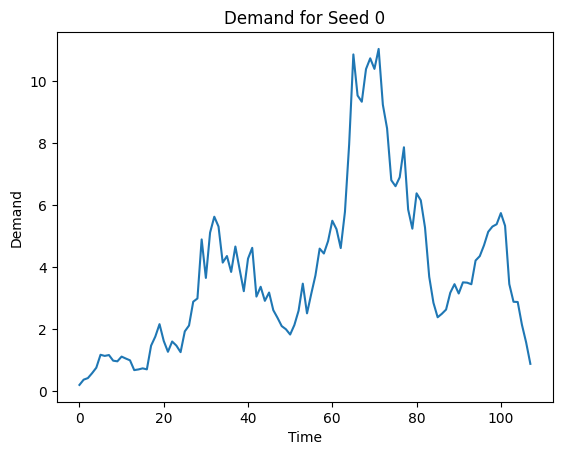

In [34]:
# Plot the historical data
plt.plot(seeded_demands[0])
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title(f"Demand for Seed 0")
plt.show()

In [35]:
seq_length = 10
demand_0 /= 100000

X_trains , X_tests, y_trains, y_tests = [],[],[],[]



for sd in seeded_demands:

    X, y = create_sequences(sd, seq_length)


    # Split the data into training and testing sets
    train_size = int(len(y) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train).float() 
    y_train = torch.from_numpy(y_train).float() 
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    
    X_trains.append(X_train)
    X_tests.append(X_test)

    y_trains.append(y_train)
    y_tests.append(y_test)




In [36]:
model = predictModel(1, 50, 2, 1)


# Set training parameters
learning_rate = 0.005
num_epochs = 10

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
# Train the model
for epoch in range(num_epochs):


    for sd in range(len(seeded_demands)):
    
        X_train = X_trains[sd]
        y_train =  y_trains[sd]

    

        outputs = model(X_train.unsqueeze(-1)).squeeze()  # Add .squeeze() here
        
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/10], Loss: 0.5788
Epoch [10/10], Loss: 0.4715
Epoch [10/10], Loss: 0.6842
Epoch [10/10], Loss: 0.4872
Epoch [10/10], Loss: 0.5658
Epoch [10/10], Loss: 0.4551
Epoch [10/10], Loss: 0.8301
Epoch [10/10], Loss: 0.1820
Epoch [10/10], Loss: 0.5059
Epoch [10/10], Loss: 0.2666
Epoch [10/10], Loss: 0.2897
Epoch [10/10], Loss: 0.4264
Epoch [10/10], Loss: 0.2315
Epoch [10/10], Loss: 0.7365
Epoch [10/10], Loss: 0.3038
Epoch [10/10], Loss: 0.0945
Epoch [10/10], Loss: 0.5346
Epoch [10/10], Loss: 0.3609
Epoch [10/10], Loss: 0.4019
Epoch [10/10], Loss: 0.2626
Epoch [10/10], Loss: 0.3465
Epoch [10/10], Loss: 0.0751
Epoch [10/10], Loss: 0.6281
Epoch [10/10], Loss: 0.2849
Epoch [10/10], Loss: 0.3908
Epoch [10/10], Loss: 0.1444
Epoch [10/10], Loss: 0.2500
Epoch [10/10], Loss: 0.3715
Epoch [10/10], Loss: 0.2957
Epoch [10/10], Loss: 0.4579
Epoch [10/10], Loss: 0.1712
Epoch [10/10], Loss: 0.3434
Epoch [10/10], Loss: 0.4626
Epoch [10/10], Loss: 0.2087
Epoch [10/10], Loss: 0.1784
Epoch [10/10], Loss:

In [38]:
for X_test, y_test in zip(X_tests,y_tests): 
    with torch.no_grad():
        test_outputs = model(X_test.unsqueeze(-1)).squeeze()  # Add .squeeze() here
        test_loss = criterion(test_outputs, y_test)
        print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.4944
Test Loss: 0.7642
Test Loss: 0.5931
Test Loss: 0.4927
Test Loss: 0.6546
Test Loss: 0.1887
Test Loss: 0.8112
Test Loss: 0.3312
Test Loss: 0.3047
Test Loss: 0.1631
Test Loss: 0.3776
Test Loss: 0.3678
Test Loss: 0.2497
Test Loss: 0.5093
Test Loss: 0.3547
Test Loss: 0.2184
Test Loss: 0.4123
Test Loss: 0.2481
Test Loss: 0.5431
Test Loss: 0.3441
Test Loss: 0.5345
Test Loss: 0.2456
Test Loss: 0.7302
Test Loss: 0.4214
Test Loss: 0.2828
Test Loss: 0.2780
Test Loss: 0.2255
Test Loss: 0.3668
Test Loss: 0.2220
Test Loss: 0.3565
Test Loss: 0.2736
Test Loss: 0.4438
Test Loss: 0.4308
Test Loss: 0.1994
Test Loss: 0.3029
Test Loss: 0.3767
Test Loss: 0.4735
Test Loss: 0.2076
Test Loss: 0.6353
Test Loss: 0.2772
Test Loss: 0.3776
Test Loss: 0.2303
Test Loss: 0.2522
Test Loss: 0.2477
Test Loss: 0.4275
Test Loss: 0.4135
Test Loss: 0.1588
Test Loss: 0.2077
Test Loss: 0.4935
Test Loss: 0.4996
Test Loss: 0.2602
Test Loss: 0.3892
Test Loss: 0.5326
Test Loss: 0.3493
Test Loss: 0.6749
Test Loss:

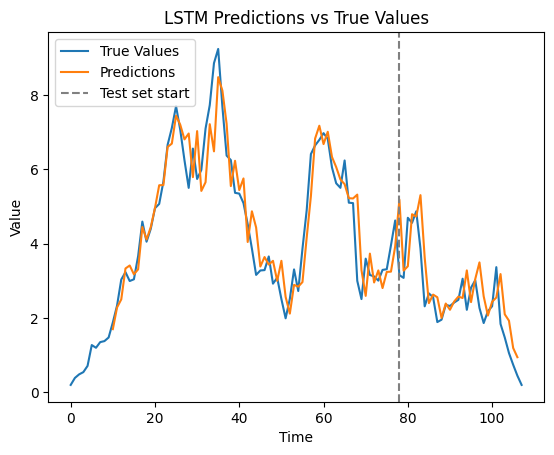

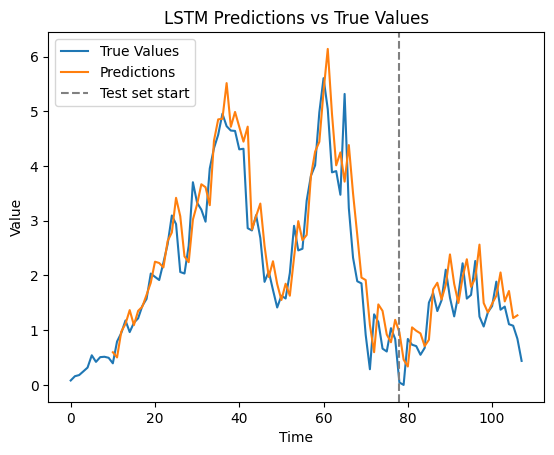

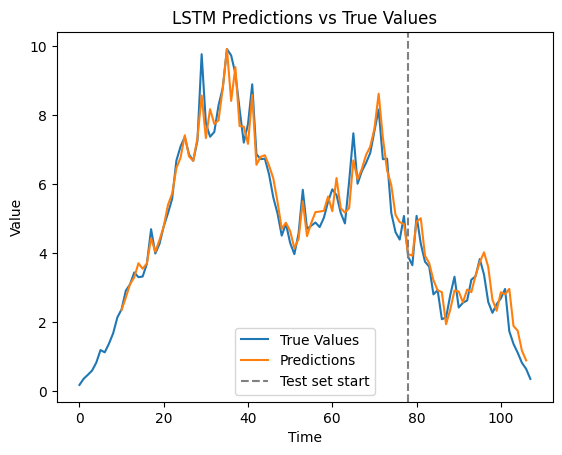

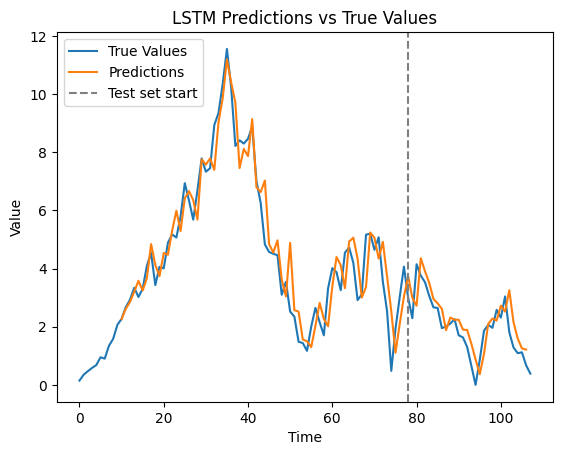

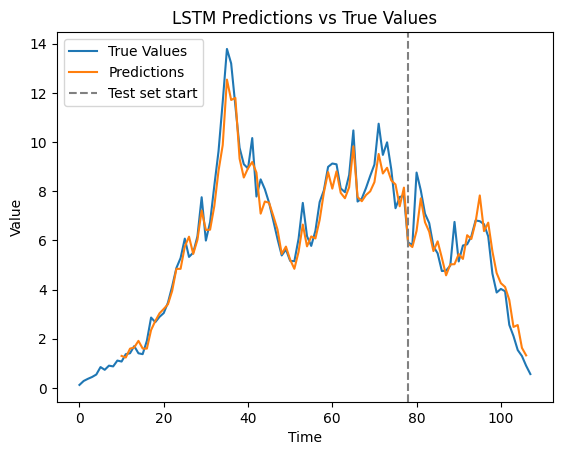

In [39]:
view = [100,300,500,700,900]

for sd in view:

    actual_demand = seeded_demands[sd]
    X_train = X_trains[sd]
    X_test = X_tests[sd]

    # Concatenate the training and test predictions
    with torch.no_grad():
        train_outputs = model(X_train.unsqueeze(-1)).squeeze().numpy()
        test_outputs = model(X_test.unsqueeze(-1)).squeeze().numpy()
        
    all_outputs = np.concatenate((train_outputs, test_outputs))


    # Calculate the index where the test set starts
    test_start_index = len(actual_demand) - len(y_test) - seq_length

    # Plot the true values and the predictions
    plt.plot(actual_demand, label="True Values")
    plt.plot(range(seq_length, seq_length + len(all_outputs)), all_outputs, label="Predictions")
    plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test set start")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.title("LSTM Predictions vs True Values")
    plt.show()


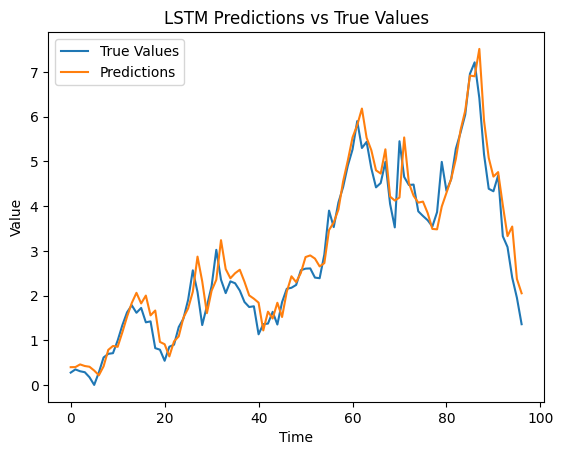

In [54]:
test  = getSeedDemand(115) 
test = test.loc[(test["server_generation"]==server_type)]["low"].reset_index(drop=True)
                 
test *= normalisation_factor
test, test_output = create_sequences(test, seq_length)

test = torch.from_numpy(test).float() 
test_output = torch.from_numpy(test_output).float() 

# Concatenate the training and test predictions
with torch.no_grad():
    model_outputs = model(test.unsqueeze(-1)).squeeze().numpy()
        

# Plot the true values and the predictions
plt.plot(test_output, label="True Values")
# plt.plot(range(seq_length, seq_length + len(model_outputs)), model_outputs, label="Predictions")
plt.plot(range(0,  len(model_outputs)), model_outputs, label="Predictions")

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()